# Русскоязычный классификатор интентов

In [1]:
from gensim.models import KeyedVectors
from keras.layers.core import Dense, SpatialDropout1D
from keras.layers.convolutional import Conv1D
from keras.layers.embeddings import Embedding
from keras.layers.pooling import GlobalMaxPooling1D
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import collections
import nltk
import numpy as np
import codecs
import pandas as pd
import gensim
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import keras
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Flatten, Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Activation
from keras.models import Model
import sklearn
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import save_model, load_model
from keras.callbacks import ModelCheckpoint
from nltk.tokenize import RegexpTokenizer

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Импорт русскоязычной модели word2vec

In [0]:
import gensim.downloader as api

In [39]:
model = api.load("word2vec-ruscorpora-300")

[==================================================] 100.0% 198.8/198.8MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Количество слов в словаре - почти 185к

In [40]:
len(model.vocab)

184973

In [41]:
model.most_similar('добавлять_VERB')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('прибавлять_VERB', 0.6648961305618286),
 ('добавление_NOUN', 0.5659074783325195),
 ('томатный::пюре_NOUN', 0.557951807975769),
 ('спассеровывать_VERB', 0.5524739027023315),
 ('лимонный::цедра_NOUN', 0.5512294769287109),
 ('тертый::мускатный_ADJ', 0.5496140122413635),
 ('спассеровать_VERB', 0.5316646099090576),
 ('пассеровывать_VERB', 0.5253649950027466),
 ('пассеровать_VERB', 0.5235322713851929),
 ('панировочный::сухарь_NOUN', 0.5202608704566956)]

Импорт размеченных русскоязычных данных

*   https://github.com/Koziev/chatbot/blob/master/data/intents.txt


In [0]:
file_excel = pd.read_excel('drive/My Drive/ForGensim/russian_train.xlsx', sheet_name='russian_train')

In [19]:
file_excel[:4]

,О_Музыке,Прогноз_Погоды,График_Работы,Заказать_Еду,Будильник
0,Оркестр играл Похоронный марш Бетховена,На следующей неделе пойдет снег?,Отделение банка работает в субботу?,Закажи две пиццы,разбуди меня завтра в шесть
1,Возьму барабаны и вступлю в рок-группу,меня интересует вероятность дождя в ближайшие ...,До скольки работает касса?,Как бесплатно заказать еду на дом или по больш...,разбуди меня завтра в шесть часов
2,Для них пелись самые разные песни,мне интересно знать усилится ли ветер после обеда,Во сколько заканчивает работу касса?,как мне заказать кумыс в Москве?,разбуди меня завтра в семь
3,Из зала доносились звуки оркестра,Идет дождь?,До которого часа касса работает?,Плюс можно заказать поесть.,разбуди меня завтра в семь часов


In [0]:
unique_intents = file_excel.columns

In [120]:
unique_intents

Index(['О_Музыке', 'Прогноз_Погоды', 'График_Работы', 'Заказать_Еду',
       'Будильник'],
      dtype='object')

In [0]:
all_texts,all_intents = [], []

for intent in unique_intents:
  for text in file_excel[intent]:
    if pd.isnull(text):
      break
    else:
      all_texts.append(text)
      all_intents.append(intent)

Подготовка данных (удаление стоп-слов, пунктуации и добавление к словам части речи для корректной работы с моделью word2vec)

In [56]:
pip install pymorphy2

     |████████████████████████████████| 51kB 1.7MB/s 
     |████████████████████████████████| 7.1MB 8.0MB/s 


In [0]:
import pymorphy2

In [0]:
def tokenize(text):
  regex_tokenizer = RegexpTokenizer('[а-яА-ЯЁё]+')
  words = regex_tokenizer.tokenize(text.lower())
  stop_words = set(stopwords.words("russian"))
  without_stop_words = [w for w in words if w not in stop_words and len(w) > 1]
  output = [add_part_of_speech(word) for word in without_stop_words]
  #print(output)
  return output

In [0]:
def add_part_of_speech(word):
  morph = pymorphy2.MorphAnalyzer()
  p = morph.parse(word)[0]
  word += '_' + str(p.tag.POS)
  return word

In [0]:
word = 'привет'

In [0]:
word = add_part_of_speech(word)

In [92]:
word

'привет_NOUN'

In [0]:
sentences = np.array([tokenize(text) for text in all_texts])

In [99]:
sentences[:5]

array([list(['оркестр_NOUN', 'играл_VERB', 'похоронный_ADJF', 'марш_INTJ', 'бетховена_NOUN']),
       list(['возьму_VERB', 'барабаны_NOUN', 'вступлю_VERB', 'рок_NOUN', 'группу_NOUN']),
       list(['пелись_VERB', 'самые_ADJF', 'разные_ADJF', 'песни_NOUN']),
       list(['зала_NOUN', 'доносились_VERB', 'звуки_NOUN', 'оркестра_NOUN']),
       list(['можете_VERB', 'посоветовать_INFN', 'хорошие_ADJF', 'душерздерающие_PRTF', 'песни_NOUN', 'любви_NOUN', 'хорошим_ADJF', 'примитивным_ADJF', 'текстом_NOUN', 'красивой_ADJF', 'музыкой_NOUN'])],
      dtype=object)

In [0]:
import collections
counter = collections.Counter()

In [0]:
#считаем максимальную длину предложений, а также частоту всех слов предложений, считанных из файла 
maxlen = 0
for words in sentences:
    if len(words) > maxlen:
        maxlen = len(words)
    for word in words:
        counter[word] += 1

Подготовка данных для обучения для основе ruscorpora

In [0]:
# Преобразование номеров классов в названия классов
def transform_from_categorical(prediction, intents):
  answers = []

  for i in range(prediction.shape[0]):
    answers.append(intents[prediction[i]])

  return answers

# Преобразование названий классов в матрицу двоичных чисел (нужно для keras)
def transform_to_categorical(intents_for_each, unique_intents):
  intents_to_digit = []

  for intent in intents_for_each:
    intents_to_digit.append(unique_intents.index(intent))

  return to_categorical(intents_to_digit, len(unique_intents))

In [0]:
vocab_sz = len(counter) + 1

In [0]:
# Создание единого словаря (слово -> число) для преобразования на основе списка текстов sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

In [0]:
X = tokenizer.texts_to_sequences(sentences) #заменяем слова каждого предложения на числа

In [107]:
X[:3]

[[127, 128, 286, 287, 288], [289, 290, 291, 16, 89], [292, 293, 294, 4]]

In [0]:
y = transform_to_categorical(all_intents, unique_intents.to_list())#заменяем названия интентов на матрицу двоичных чисел

In [131]:
y[:3]

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [0]:
X = pad_sequences(X, maxlen = maxlen) #уравниваем все предложения до размера maxlen

In [133]:
X[:3]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0, 127, 128, 286, 287, 288],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0, 289, 290, 291,  16,  89],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0, 292, 293, 294,   4]], dtype=int32)

In [135]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.2, random_state = 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(288, 21) (72, 21) (288, 5) (72, 5)


Создание keras модели

In [0]:
EMBED_SIZE = 300
NUM_FILTERS = 256
NUM_WORDS = 3
BATCH_SIZE = 64
NUM_EPOCHS = 10

In [0]:
embedding_weights = np.zeros((vocab_sz, EMBED_SIZE))#создаём матрицу размером размерность словаря*размерность вектора слова
index = 0
sorted_counter = counter.most_common() #сортируем слова по частоте встречаемости
for word in sorted_counter:#для каждого слова из нашего словаря задаём вектор из model в матрицу
    try:
      embedding_weights[index, :] = model[word[0]] 
      index+=1     
    except KeyError:#если нет слова в словаре model
      index+=1
      pass

In [0]:
COUNT_CLASSES = len(unique_intents)

In [0]:
# Создание модели
def get_model(COUNT_CLASSES, embedding_weights):
  kmodel = Sequential()
  kmodel.add(Embedding(vocab_sz, EMBED_SIZE, input_length = maxlen,
                      weights = [embedding_weights],
                      trainable = True))
  kmodel.add(SpatialDropout1D(0.2))
  kmodel.add(Conv1D(filters = NUM_FILTERS, kernel_size = NUM_WORDS,
                  activation = "relu"))
  kmodel.add(GlobalMaxPooling1D())
  kmodel.add(Dense(COUNT_CLASSES, activation="softmax"))

  kmodel.compile(optimizer = "adam", loss = "categorical_crossentropy",
                metrics = ["accuracy"])
  
  return kmodel

In [141]:
keras_model = get_model(COUNT_CLASSES, embedding_weights)











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [142]:
keras_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 21, 300)           357000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 21, 300)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 19, 256)           230656    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 588,941
Trainable params: 588,941
Non-trainable params: 0
_________________________________________________________________


Обучение keras модели

In [143]:
history = keras_model.fit(X_train, y_train, batch_size = BATCH_SIZE,
                    epochs = NUM_EPOCHS,
                    callbacks=[ModelCheckpoint('drive/My Drive/ForGensim/rus_keras_model.h5', save_best_only = True)],
                    validation_split = 0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 230 samples, validate on 58 samples
Epoch 1/10
230/230 [==============================] - 1s 4ms/step - loss: 1.5947 - acc: 0.4087 - val_loss: 1.4972 - val_acc: 0.6552
Epoch 2/10
230/230 [==============================] - 0s 1ms/step - loss: 1.4254 - acc: 0.6043 - val_loss: 1.3671 - val_acc: 0.6379
Epoch 3/10
230/230 [==============================] - 0s 1ms/step - loss: 1.2702 - acc: 0.5913 - val_loss: 1.2394 - val_acc: 0.6379
Epoch 4/10
230/230 [==============================] - 0s 1ms/step - loss: 1.1103 - acc: 0.6000 - val_loss: 1.1071 - val_acc: 0.6724
Epoch 5/10
230/230 [==============================] - 0s 1ms/step - loss: 0.9455 - acc: 0.6609 - val_loss: 0.9636 - val_acc: 0.7241
Epoch 6/10
230/230 [==============================] - 0s 1ms/step - loss: 0.7715 - acc: 0.7870 - val_loss: 0.8108 - val_acc: 0.8103
Epoch 7/10
230/230 [==============================] - 0s 1ms/step -

In [144]:
score = keras_model.evaluate(X_test, y_test)
print("Test accuracy: {:.3f}".format(score[1]))

72/72 [==============================] - 0s 418us/step
Test accuracy: 0.917


Модель обучилась с точностью ~91%

In [0]:
prediction = keras_model.predict_classes(X_test)

In [0]:
y_test_ = []
y_test = y_test.tolist()
for i in range(len(y_test)):
  y_test_.append(unique_intents[y_test[i].index(1)])

In [0]:
prediction_ = transform_from_categorical(prediction, unique_intents)

In [0]:
import seaborn as sn

In [0]:
import matplotlib.pyplot as plt

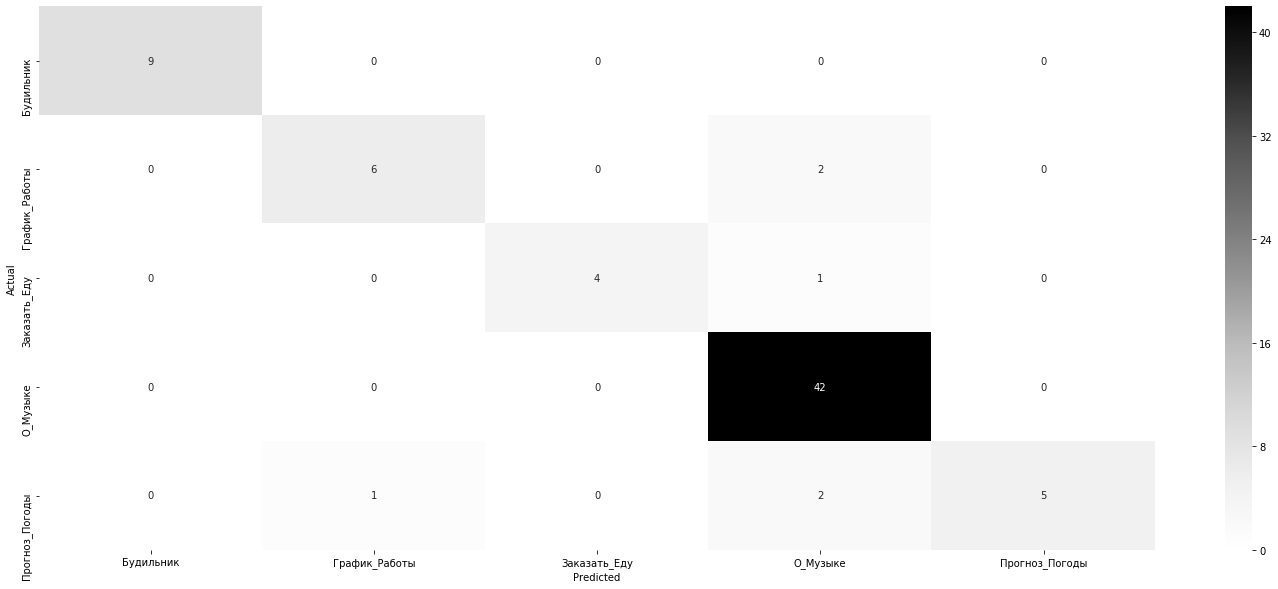

In [150]:
data = {'prediction': prediction_,
        'actual':    y_test_
        }

df = pd.DataFrame(data, columns = ['actual','prediction'])
confusion_matrix = pd.crosstab(df['actual'], df['prediction'], rownames = ['Actual'], colnames = ['Predicted'])
plt.figure(figsize=(25, 10))
sn.heatmap(confusion_matrix, annot=True,cmap="Greys")

Тестирование (проверка работы) классификатора на небольших данных

In [0]:
test = ['какая погода в Кирове', 'во сколько закрывается аптека', 'я люблю слушать музыку в наушниках', 
        'додо пицца заказать онлайн', 'разбудите меня в семь вечера'] 

In [0]:
test_sentence = np.array([tokenize(text) for text in test])

In [155]:
sequences_test = tokenizer.texts_to_sequences(test_sentence)
sequences_test

[[23], [8, 82], [220, 17, 2], [9], [33]]

In [0]:
X_predict = pad_sequences(sequences_test, maxlen = maxlen)

In [0]:
prediction = keras_model.predict_classes(X_predict)

In [159]:
answers = transform_from_categorical(prediction, unique_intents.to_list()) 
answers

['Прогноз_Погоды', 'График_Работы', 'О_Музыке', 'Заказать_Еду', 'Будильник']